<h1 align='center'>BMIG 6201 Spring 2021</h1>

<h2 align='center'>Predicting Breast Cancer Recurrence Using Machine Learning</h2>

<h3 align='center'>Jonathan Laryea </h3>

# Introduction
* Breast Cancer is the most common cancer in females in the United States. 
* It is also the second leading cause of cancer deaths in women in the United States. 
* Breast Cancer is treated with a combination of surgery, chemotherapy, radiation, hormonal therapy and immunotherapy. 
* When the cancer is treated at an early stage, the survival is good. 
* However, when it is discovered at a later stage, the survival is not that good. 
* Some of the cancers will recur either in the same breast or in the other breast. Recurrences can also occur in other parts of the body like the lungs, liver, breast and brain. 
* It is not clear which patients will develop a recurrence. 
* Being able to determine recurrence can help to change the treatments from more traditional forms to more aggressive regimens. 



# Introdution

**Objective**: To predict  cancer recurrence using machine learning algorithms  

**Algorithms**: Classification algorithms: Logistic Regression, Naivebayes, KNN, RandomForest, DecisionTree, SVC, LDA, QDA 

Tune models with cross-validation and GridSearchCV to find the optimum hyperparameters. 

**Data source**: The dataset for the project is the [breast-cancer-data](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/) dataset from the UCI archives  
 
url: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/


# Methods  
* Obtain the data
* Do exploratory data analysis
* Feature engineering
* Feature selection
* Divide data into training and testing sets
* Apply classification algorithms and calculate metrics (accuracy, confusion matrix, precision, recall, F1-score, AUC
* Tune the algorithms using cross-validation and GridSearchCV
* Determine the best algorithm
* Report results

# Load required libraries

In [3]:
import pandas as pd  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix

%matplotlib inline
plt.style.use('ggplot')

# Load the data

In [4]:
df = pd.read_csv('breast-cancer.data')

df.head()

,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no.1
0,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
2,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
3,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
4,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no


In [5]:
 
columns = [ 'Class', 'age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat']
df.columns = columns
df.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
2,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
3,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
4,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no


In [5]:
df.dtypes

Class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        285 non-null    object
 1   age          285 non-null    object
 2   menopause    285 non-null    object
 3   tumor-size   285 non-null    object
 4   inv-nodes    285 non-null    object
 5   node-caps    285 non-null    object
 6   deg-malig    285 non-null    int64 
 7   breast       285 non-null    object
 8   breast-quad  285 non-null    object
 9   irradiat     285 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.4+ KB


In [7]:
X = df.drop('Class', axis=1)
y = df['Class']

X.shape, y.shape

((285, 9), (285,))

In [8]:

for col_name in X.columns:
    if X[col_name].dtypes == 'object':
        unique_cat = len(X[col_name].unique())
        print("Feature '{col_name}' has '{unique_cat}' unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'age' has '6' unique categories
Feature 'menopause' has '3' unique categories
Feature 'tumor-size' has '11' unique categories
Feature 'inv-nodes' has '7' unique categories
Feature 'node-caps' has '3' unique categories
Feature 'breast' has '2' unique categories
Feature 'breast-quad' has '6' unique categories
Feature 'irradiat' has '2' unique categories


In [9]:
todummy_list = ['menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat', 'age', 'tumor-size', 'inv-nodes']
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, axis=1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [10]:
X = dummy_df(X, todummy_list)



In [11]:
y = pd.get_dummies(y, drop_first=True)

In [12]:
X.isnull().sum().sort_values(ascending=False).head()

inv-nodes_9-11    0
age_40-49         0
age_20-29         0
irradiat_yes      0
irradiat_no       0
dtype: int64

## Check for Interactions and Remove significant Interactions

In [15]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

In [16]:
def add_interactions(df):
    #get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    #find interactions
    poly = PolynomialFeatures(interaction_only = True, include_bias = False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    #remove interaction terms with all 0 values
    noint_indices = [i for i, x in enumerate(list((df == 0).all()))if x]
    df = df.drop(df.columns[noint_indices], axis=1)
    
    return df

In [17]:
X = add_interactions(X)
X.head()

,deg-malig,menopause_ge40,menopause_lt40,menopause_premeno,node-caps_?,node-caps_no,node-caps_yes,breast_left,breast_right,breast-quad_?,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_no,irradiat_yes,age_20-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,tumor-size_0-4,tumor-size_10-14,tumor-size_15-19,tumor-size_20-24,tumor-size_25-29,tumor-size_30-34,tumor-size_35-39,tumor-size_40-44,tumor-size_45-49,tumor-size_5-9,tumor-size_50-54,inv-nodes_0-2,inv-nodes_12-14,inv-nodes_15-17,inv-nodes_24-26,inv-nodes_3-5,inv-nodes_6-8,...,age_70-79_inv-nodes_0-2,age_70-79_inv-nodes_9-11,tumor-size_0-4_inv-nodes_0-2,tumor-size_10-14_inv-nodes_0-2,tumor-size_10-14_inv-nodes_3-5,tumor-size_10-14_inv-nodes_6-8,tumor-size_15-19_inv-nodes_0-2,tumor-size_15-19_inv-nodes_12-14,tumor-size_15-19_inv-nodes_15-17,tumor-size_15-19_inv-nodes_6-8,tumor-size_15-19_inv-nodes_9-11,tumor-size_20-24_inv-nodes_0-2,tumor-size_20-24_inv-nodes_24-26,tumor-size_20-24_inv-nodes_3-5,tumor-size_20-24_inv-nodes_6-8,tumor-size_25-29_inv-nodes_0-2,tumor-size_25-29_inv-nodes_12-14,tumor-size_25-29_inv-nodes_15-17,tumor-size_25-29_inv-nodes_3-5,tumor-size_25-29_inv-nodes_6-8,tumor-size_25-29_inv-nodes_9-11,tumor-size_30-34_inv-nodes_0-2,tumor-size_30-34_inv-nodes_12-14,tumor-size_30-34_inv-nodes_15-17,tumor-size_30-34_inv-nodes_3-5,tumor-size_30-34_inv-nodes_6-8,tumor-size_30-34_inv-nodes_9-11,tumor-size_35-39_inv-nodes_0-2,tumor-size_35-39_inv-nodes_15-17,tumor-size_35-39_inv-nodes_6-8,tumor-size_35-39_inv-nodes_9-11,tumor-size_40-44_inv-nodes_0-2,tumor-size_40-44_inv-nodes_15-17,tumor-size_40-44_inv-nodes_3-5,tumor-size_40-44_inv-nodes_6-8,tumor-size_45-49_inv-nodes_0-2,tumor-size_45-49_inv-nodes_6-8,tumor-size_5-9_inv-nodes_0-2,tumor-size_50-54_inv-nodes_0-2,tumor-size_50-54_inv-nodes_9-11
0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimensionality Reduction using PCA

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)

X_pca = pd.DataFrame(pca.fit_transform(X))

X_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,2.974624,-2.806047,0.417706,-0.163285,-0.736877,1.315988,-1.025774,-0.508666,1.421643,-0.163682
1,1.269802,-1.211792,-3.868729,-0.533597,0.562374,1.544171,-0.836108,-1.909369,1.700414,0.336524
2,-2.034261,-2.194094,3.488823,-1.201067,1.227062,0.210023,-0.720965,-0.226330,-1.635058,0.276345
3,2.885793,-2.552770,0.094699,-0.509133,-0.513037,0.432348,-0.606057,0.530639,0.297994,-1.066763
4,-3.627114,-0.203887,-1.492604,-2.526401,0.745245,1.172635,-0.744241,-0.002191,-1.188368,0.224726


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((199, 564), (86, 564), (199, 1), (86, 1))

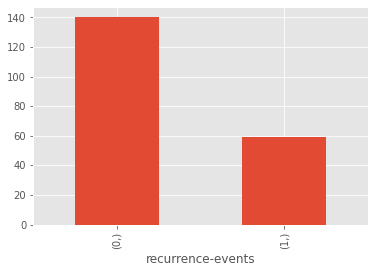

In [20]:
y_train.value_counts().plot(kind='bar')

In [21]:

print("Before OverSampling, counts of Recurrent Class '1': ",y_train.value_counts()[0])
print("Before OverSampling, counts of No-Recurrent Class '0': \n", y_train.value_counts()[1])

Before OverSampling, counts of Recurrent Class '1':  recurrence-events
0                    140
dtype: int64
Before OverSampling, counts of No-Recurrent Class '0': 
 recurrence-events
1                    59
dtype: int64


In [22]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_sample(X_train, np.ravel(y_train))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [23]:
print('After OverSampling, the shape of features_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of Output_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of Recurrent Class '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of Non-Recurrent Class '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of features_X: (280, 564)
After OverSampling, the shape of Output_y: (280,) 

After OverSampling, counts of Recurrent Class '1': 140
After OverSampling, counts of Non-Recurrent Class '0': 140


In [24]:
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=20)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  9  17  37  49  57  77  86 112 122 126 127 144 156 175 176 185 193 207
 241 245 272 283 297 306 307 308 309 311 326 334 343 348 386 390 393 399
 406 410 414 440 448 454 458 459 468 481 516 521 525 532 534 536 538 544
 559] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [25]:
colnames_selected

['deg-malig',
 'node-caps_no',
 'node-caps_yes',
 'inv-nodes_0-2',
 'deg-malig_node-caps_yes',
 'deg-malig_breast_left',
 'deg-malig_irradiat_yes',
 'deg-malig_age_30-39',
 'menopause_ge40_inv-nodes_0-2',
 'menopause_premeno_node-caps_yes',
 'node-caps_no_irradiat_no',
 'node-caps_no_inv-nodes_0-2',
 'node-caps_yes_breast_left',
 'node-caps_yes_breast-quad_left_low',
 'breast_left_irradiat_yes',
 'breast_left_age_30-39',
 'breast_left_inv-nodes_6-8',
 'breast-quad_left_low_inv-nodes_6-8',
 'irradiat_no_inv-nodes_0-2',
 'irradiat_yes_inv-nodes_6-8']

## Logistic Regression Model

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

def lr_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_hat = [x[1] for x in model.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_hat)
    
    return auc

In [27]:
auc_processed = lr_model(X_train_selected, X_test_selected, np.ravel(y_train), np.ravel(y_test))
auc_processed

0.6698717948717948

In [28]:
lr = LogisticRegression()
lr.fit(X_train_selected, np.ravel(y_train))

lr_pred = lr.predict(X_test_selected)

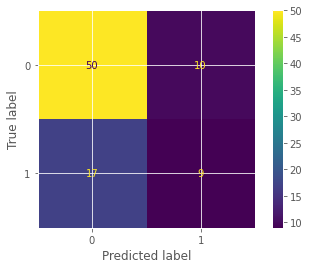

In [29]:
plot_confusion_matrix(lr, X_test_selected,y_test)

In [30]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79        60
           1       0.47      0.35      0.40        26

    accuracy                           0.69        86
   macro avg       0.61      0.59      0.59        86
weighted avg       0.66      0.69      0.67        86



## Evaluate Model with RepeatedSratidiedKFold Cross Validation

In [31]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(lr, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.7342105263157894


## Tune the LR model with GridSearchCV

In [32]:
# define grid
grid = {'penalty': ['I1', 'I2', 'elasticnet', 'none'], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'multi_class': ['auto', 'ovr', 'multinomial'], 'max_iter': [100, 200, 300]}

# define search
search = GridSearchCV(lr, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
lr_results = search.fit(X_train_selected, y_train)




/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [33]:
# summarize
print('Mean Accuracy: %.5f' % lr_results.best_score_)
print()
print('-'*100)
print('The best estimator of the logistic regression model: ', lr_results.best_estimator_)
print()
print('-'*100)
print('The best index of the logistic regression model: ', lr_results.best_index_)
print()
print('-'*100)
print('The best parameter of the logistic regression. model: ', lr_results.best_params_)
print()
print('-'*100)
print('The best score of the logistic regression model: ', lr_results.best_score_)

Mean Accuracy: 0.71588

----------------------------------------------------------------------------------------------------
The best estimator of the logistic regression model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

----------------------------------------------------------------------------------------------------
The best index of the logistic regression model:  18

----------------------------------------------------------------------------------------------------
The best parameter of the logistic regression. model:  {'max_iter': 100, 'multi_class': 'auto', 'penalty': 'none', 'solver': 'sag'}

----------------------------------------------------------------------------------------------------
The 

## Random Forest Model

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

def rf_model(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = [x[1] for x in rf.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_pred)
    return auc
  


In [35]:
rf_model(X_train_selected, X_test_selected, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.648076923076923

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


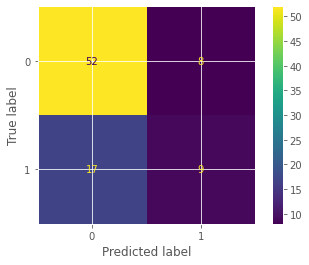

In [36]:
rf=RandomForestClassifier()
rf.fit(X_train_selected, y_train)
rf_pred = rf.predict(X_test_selected)
plot_confusion_matrix(rf, X_test_selected, y_test)


In [37]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81        60
           1       0.53      0.35      0.42        26

    accuracy                           0.71        86
   macro avg       0.64      0.61      0.61        86
weighted avg       0.69      0.71      0.69        86



## Evaluate the RF Model with RepeatedStratifiedKFold Cross Validation

In [38]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(rf, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.6755263157894736


In [39]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Tune the RF Model with GridSearchCV

In [40]:
from sklearn.model_selection import GridSearchCV
RandomForestClassifier()
# define grid
grid = {'n_estimators': [100, 200], 'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [int, None], 'bootstrap': [True, False] }

# define search
search = GridSearchCV(rf, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
rf_results = search.fit(X_train_selected, y_train)

# summarize


Mean Accuracy: 0.697
The best parameters of the random forest model: {'bootstrap': False, 'criterion': 'entropy', 'max_leaf_nodes': None, 'n_estimators': 100}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [41]:
print('The best estimator of the random forest model: ', rf_results.best_estimator_)
print()
print('-'*100)
print('The best index of the random forest model: ', rf_results.best_index_)
print()
print('-'*100)
print('The best parameter of the random forest model: ', rf_results.best_params_)
print()
print('-'*100)
print('The best score of the random forest model: ', rf_results.best_score_)


The best estimator of the random forest model:  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

----------------------------------------------------------------------------------------------------
The best index of the random forest model:  14

----------------------------------------------------------------------------------------------------
The best parameter of the random forest model:  {'bootstrap': False, 'criterion': 'entropy', 'max_leaf_nodes': None, 'n_estimators': 100}

-----------

## Decision Tree Model

In [42]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train_selected, y_train)
dt_pred = dt.predict(X_test_selected)

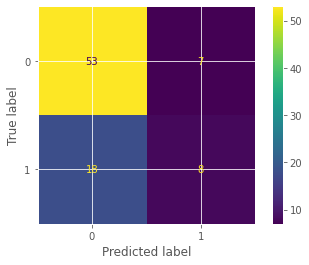

In [43]:
plot_confusion_matrix(dt, X_test_selected, y_test)

In [44]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        60
           1       0.53      0.31      0.39        26

    accuracy                           0.71        86
   macro avg       0.64      0.60      0.60        86
weighted avg       0.68      0.71      0.68        86



In [45]:

#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(dt, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.6789473684210525


In [46]:

# define grid
grid = {'splitter': ['random', 'best'], 'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [int, None], 'max_features': ['auto', 'sqrt', 'log2']}

# define search
search = GridSearchCV(dt, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
dt_results = search.fit(X_train_selected, y_train)



In [47]:
print('The best estimator of the decision tree model: ', dt_results.best_estimator_)
print()
print('-'*100)
print('The best index of the decision tree model: ', dt_results.best_index_)
print()
print('-'*100)
print('The best parameter of the decision tree model: ', dt_results.best_params_)
print()
print('-'*100)
print('The best score of the decision tree model: ', dt_results.best_score_)

The best estimator of the decision tree model:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

----------------------------------------------------------------------------------------------------
The best index of the decision tree model:  22

----------------------------------------------------------------------------------------------------
The best parameter of the decision tree model:  {'criterion': 'entropy', 'max_features': 'log2', 'max_leaf_nodes': None, 'splitter': 'random'}

----------------------------------------------------------------------------------------------------
The best score of the 

## Naive Bayes Model

In [48]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_selected, y_train)
gnb_pred = gnb.predict(X_test_selected)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:

#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(gnb, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.7359649122807017


In [50]:

# define grid
grid = {'priors': [None], 'var_smoothing': [1e-09]}

# define search
search = GridSearchCV(gnb, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
gnb_results = search.fit(X_train_selected, y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
print('The best estimator of the naive bayes model: ', gnb_results.best_estimator_)
print()
print('-'*100)
print('The best index of the naive bayes model: ', gnb_results.best_index_)
print()
print('-'*100)
print('The best parameter of the naive bayes model: ', gnb_results.best_params_)
print()
print('-'*100)
print('The best score of the naive bayes model: ', gnb_results.best_score_)

The best estimator of the naive bayes model:  GaussianNB(priors=None, var_smoothing=1e-09)

----------------------------------------------------------------------------------------------------
The best index of the naive bayes model:  0

----------------------------------------------------------------------------------------------------
The best parameter of the naive bayes model:  {'priors': None, 'var_smoothing': 1e-09}

----------------------------------------------------------------------------------------------------
The best score of the naive bayes model:  0.7359649122807017


## K Nearest Neighbors

In [52]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_selected, y_train)

knn_pred = knn.predict(X_test_selected)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


In [53]:
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(knn, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  



0.7223684210526315


In [54]:
# define grid
grid = {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [30, 40, 50], 'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance']}

# define search
search = GridSearchCV(knn, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
knn_results = search.fit(X_train_selected, y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [55]:
print('The best estimator of the KNN model: ', knn_results.best_estimator_)
print()
print('-'*100)
print('The best index of the KNN model: ', knn_results.best_index_)
print()
print('-'*100)
print('The best parameter of the KNN model: ', knn_results.best_params_)
print()
print('-'*100)
print('The best score of the KNN model: ', knn_results.best_score_)

The best estimator of the KNN model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

----------------------------------------------------------------------------------------------------
The best index of the KNN model:  2

----------------------------------------------------------------------------------------------------
The best parameter of the KNN model:  {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 10, 'weights': 'uniform'}

----------------------------------------------------------------------------------------------------
The best score of the KNN model:  0.7542982456140351


## Linear Discriminant Analysis

In [56]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
lda.fit(X_train_selected, y_train)

lda_pred = lda.predict(X_test_selected)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(lda, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  



0.707280701754386


In [58]:
# define grid
grid = {'solver': ['svd', 'lsqr', 'eigen'], 'shrinkage': np.arange(0, 1, 0.01), 'n_components': [0, 1, 2] }

# define search
search = GridSearchCV(lda, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
lda_results = search.fit(X_train_selected, y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [59]:
print('The best estimator of the LDA model: ', lda_results.best_estimator_)
print()
print('-'*100)
print('The best index of the LDA model: ', lda_results.best_index_)
print()
print('-'*100)
print('The best parameter of the LDA model: ', lda_results.best_params_)
print()
print('-'*100)
print('The best score of the LDA model: ', lda_results.best_score_)

The best estimator of the LDA model:  LinearDiscriminantAnalysis(n_components=0, priors=None, shrinkage=0.29,
                           solver='lsqr', store_covariance=False, tol=0.0001)

----------------------------------------------------------------------------------------------------
The best index of the LDA model:  88

----------------------------------------------------------------------------------------------------
The best parameter of the LDA model:  {'n_components': 0, 'shrinkage': 0.29, 'solver': 'lsqr'}

----------------------------------------------------------------------------------------------------
The best score of the LDA model:  0.7407894736842106


## Quadratic Discriminant Analysis

In [60]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [61]:
qda = QDA()
qda.fit(X_train_selected, y_train)
qda_pred = qda.predict(X_test_selected)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [62]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(qda, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.6162280701754386


In [63]:
grid = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001,0.01, 0.1), 
                   }
# define search
qda_search = GridSearchCV(qda, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
qda_results = qda_search.fit(X_train, y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [64]:
print('The best estimator of the model: ', qda_results.best_estimator_)
print()
print('-'*100)
print('The best index of the model: ', qda_results.best_index_)
print()
print('-'*100)
print('The best parameter of the model: ', qda_results.best_params_)
print()
print('-'*100)
print('The best score of the model: ', qda_results.best_score_)


The best estimator of the model:  QuadraticDiscriminantAnalysis(priors=None, reg_param=0.01,
                              store_covariance=True, tol=0.0001)

----------------------------------------------------------------------------------------------------
The best index of the model:  24

----------------------------------------------------------------------------------------------------
The best parameter of the model:  {'reg_param': 0.01, 'store_covariance': True, 'tol': 0.0001}

----------------------------------------------------------------------------------------------------
The best score of the model:  0.7471052631578947


## Compare Models

In [65]:
models = {'model': ['Logistic Regression', 'Random Forest', 'Decision Tree', 'Gaussian Naive Bayes', 'K Nearest Neighbors', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis'],
          'best_scores': [lr_results.best_score_, rf_results.best_score_, dt_results.best_score_, gnb_results.best_score_, knn_results.best_score_, lda_results.best_score_, qda_results.best_score_]}

compare_models = pd.DataFrame(models)
compare_models

,model,best_scores
0,Logistic Regression,0.715877
1,Random Forest,0.697368
2,Decision Tree,0.704035
3,Gaussian Naive Bayes,0.735965
4,K Nearest Neighbors,0.754298
5,Linear Discriminant Analysis,0.740789
6,Quadratic Discriminant Analysis,0.747105


In [66]:
compare_models.sort_values('best_scores', ascending=False)

,model,best_scores
4,K Nearest Neighbors,0.754298
6,Quadratic Discriminant Analysis,0.747105
5,Linear Discriminant Analysis,0.740789
3,Gaussian Naive Bayes,0.735965
0,Logistic Regression,0.715877
2,Decision Tree,0.704035
1,Random Forest,0.697368


## Artificial Neural Network Model Using Keras

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import sparse_categorical_crossentropy
from keras.metrics import Accuracy

In [ ]:
model = Sequential(
    [
        keras.Input(shape=(X_train_selected.shape[1],)),
        Dense(20, activation='relu', name='layer1'),
        Dense(10, activation='relu', name='layer2'),
        Dense(5, activation='relu', name='layer3'),
        Dense(1, name='layer4')
    ])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics='Accuracy')

In [ ]:
model.fit(X_train_selected, y_train, epochs=20, batch_size=20, verbose=0)


In [ ]:
model.evaluate(X_test_selected, y_test, verbose=2)

3/3 - 0s - loss: 0.1962 - accuracy: 0.0000e+00


[0.1961711198091507, 0.0]

In [ ]:
model.predict(X_test_selected, batch_size=32, verbose=1)[:10]

3/3 [==============================] - 0s 4ms/step


array([[0.18526368],
       [0.10911795],
       [0.43303433],
       [0.27718818],
       [0.50732654],
       [0.67074513],
       [0.27718818],
       [0.24392019],
       [0.8143382 ],
       [0.18158345]], dtype=float32)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 20)                420       
_________________________________________________________________
layer2 (Dense)               (None, 10)                210       
_________________________________________________________________
layer3 (Dense)               (None, 5)                 55        
_________________________________________________________________
layer4 (Dense)               (None, 1)                 6         
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def regression_model():
    model = Sequential()
    model.add(Dense(20, activation='relu', input_shape = (X_train_selected.shape[1],)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
model = regression_model()

In [ ]:
model.fit(X_train_selected, y_train, validation_data = (X_test_selected, y_test), epochs=50, verbose=2)

Epoch 1/50
7/7 - 1s - loss: 0.6956 - val_loss: 0.6852
Epoch 2/50
7/7 - 0s - loss: 0.6588 - val_loss: 0.6496
Epoch 3/50
7/7 - 0s - loss: 0.6254 - val_loss: 0.6160
Epoch 4/50
7/7 - 0s - loss: 0.5911 - val_loss: 0.5812
Epoch 5/50
7/7 - 0s - loss: 0.5558 - val_loss: 0.5468
Epoch 6/50
7/7 - 0s - loss: 0.5200 - val_loss: 0.5092
Epoch 7/50
7/7 - 0s - loss: 0.4767 - val_loss: 0.4675
Epoch 8/50
7/7 - 0s - loss: 0.4275 - val_loss: 0.4194
Epoch 9/50
7/7 - 0s - loss: 0.3728 - val_loss: 0.3682
Epoch 10/50
7/7 - 0s - loss: 0.3203 - val_loss: 0.3231
Epoch 11/50
7/7 - 0s - loss: 0.2755 - val_loss: 0.2903
Epoch 12/50
7/7 - 0s - loss: 0.2504 - val_loss: 0.2667
Epoch 13/50
7/7 - 0s - loss: 0.2321 - val_loss: 0.2529
Epoch 14/50
7/7 - 0s - loss: 0.2234 - val_loss: 0.2435
Epoch 15/50
7/7 - 0s - loss: 0.2171 - val_loss: 0.2376
Epoch 16/50
7/7 - 0s - loss: 0.2135 - val_loss: 0.2334
Epoch 17/50
7/7 - 0s - loss: 0.2115 - val_loss: 0.2303
Epoch 18/50
7/7 - 0s - loss: 0.2093 - val_loss: 0.2275
Epoch 19/50
7/7 - 0

In [ ]:
predictions = model.predict(X_test_selected)

In [ ]:
predictions.shape

(86, 1)

In [ ]:
predictions[0:10]

array([[0.20979832],
       [0.11312766],
       [0.41476333],
       [0.27393952],
       [0.06392576],
       [0.43345553],
       [0.27393952],
       [0.121886  ],
       [0.41062498],
       [0.19841614]], dtype=float32)

In [ ]:
predictions = predictions.flatten()


In [ ]:
y1 = y_test.reset_index()

In [ ]:
y1 = y1.iloc[:,1]

In [ ]:
preds = ({'Actual': y1, 'Predicted': predictions})

pd.DataFrame(preds)

,Actual,Predicted
0,0,0.209798
1,0,0.113128
2,0,0.414763
3,1,0.273940
4,1,0.063926
...,...,...
81,0,0.143971
82,1,0.364882
83,0,0.138410
84,1,0.433876


In [ ]:
mse = mean_squared_error(y_test, predictions)
mse

0.2069986